### For the purpose of illustrating how to run the code, we replicate the results of POTION in Figure 2. 

In [5]:
import pickle
import seaborn
import pandas as pd
import matplotlib.pylab as plt

%matplotlib inline 
%load_ext autoreload

# plt.style.use('seaborn-paper')
# seaborn.set_context('paper', font_scale=2.2)
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.weight'] = 'medium'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0. Make sure you are under the `src/` folder. Create a folder to store results in the upper-level directory, i.e.,  `mkdir ../result`

### 1.  Run the following command to attack the Email network.

The arguments to main.py are:
   - `--graph_type:` specify which network to attack.
   - `--mode:` specify the trade-off parameters $(\alpha_1, \alpha_2, \alpha_3)$, e.g., "equalAlpha" means $(\alpha_1=1/3, \alpha_2=1/3, \alpha_3=1/3)$.
   - `--numExp:` the number of networks to attack. For real-world networks (including the Airport, Email, and Brain networks), this parameters is always set to $1$; for synthetic networks it is set to $30$, i.e., we attack $30$ randomly generated synthetic networks.
   - `--weighted:` specify whether the network is weighted.
   - `--save_result:` whether to save the attacked results.


In [ ]:
run main.py --graph_type=Email --mode=equalAlpha --numExp=1 --weighted=0 --save_result=1

### 2. Next, we simulate the SIS spreading dynamics on both the original and attacked networks. 


The complete argument list of the `sis_simulations.py` function is as follows:
   - `--graph_type:` specify which network to attack.
   - `--numExp:` the number of networks to attack. For real-world networks (including the Airport, Email, and Brain networks), this parameters is always set to $1$; for synthetic networks it is set to $30$, i.e., we attack $30$ randomly generated synthetic networks.
   - `--numSim:` the number of simulations to run;
   - `--numCPU:` the number of CPUs to run the simulation; the default is $4$;
   - `--gamma:` the recovery rate of the SIS dynamics;
   - `--tau:` the transmission rate of the SIS dynamics;
   - `--weighted:` whether the network is weighted.


In [ ]:
run sis_simulations.py --graph_type=Email --numExp=1 --gamma=0.24 --tau=0.06 --weighted=weighted --numSim=2000

### 3. After the simulation is done, we generate the resulting plot with the following code:

#### 3.1 First, define the plotting function as follows:

In [1]:
def plot(graph_type='Email', graph_weight='unweighted', \
         GAMMA=0.24, TAU=0.06):
    numExp = 1 if graph_type in ['Email', 'Airport', 'Brain'] else 30

    D = []
    D_err = []
    with open('../result/{}/{}-SIS/Gamma-{:.2f}---Tau-{:.2f}/{}_numExp_{}_SIS_equalAlpha.p'.format(\
                                                    graph_weight, graph_type, GAMMA, TAU, graph_type, numExp), 'rb') as fid:
        data = pickle.load(fid)
    data = data[~(data['ratio targets'].isin([0]) & data['ratio bystanders'].isin([0]))]
    data = data.dropna()

    SP_err = []
    Key = 'ratio bystanders'
    for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
        a = data[data['graph'].isin(['attacked']) & data['budget'].isin([budget])][Key] 
        a.index = range(len(a))
        b = data[data['graph'].isin(['original']) & data['budget'].isin([budget])][Key]
        b.index = range(len(b))
        SP_err.append((a-b).sem() * 1.96)

    S_err = []
    Key = 'ratio targets'
    for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
        a = data[data['graph'].isin(['attacked']) & data['budget'].isin([budget])][Key] 
        a.index = range(len(a))
        b = data[data['graph'].isin(['original']) & data['budget'].isin([budget])][Key]
        b.index = range(len(b))
        S_err.append((a-b).sem() * 1.96)

    S_attacked = data.pivot_table(index=['graph', 'budget'])['ratio targets']['attacked']
    S_original = data.pivot_table(index=['graph', 'budget'])['ratio targets']['original']
    SP_attacked = data.pivot_table(index=['graph', 'budget'])['ratio bystanders']['attacked']
    SP_original = data.pivot_table(index=['graph', 'budget'])['ratio bystanders']['original']
    S_diff  = S_attacked - S_original
    SP_diff = SP_attacked - SP_original
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge are off

    x = [0.1, 0.2, 0.3, 0.4, 0.5]
    plt.errorbar(x, S_diff, yerr=S_err, label='$G_S$', linewidth=3, 
                 markersize=5, capsize=5, elinewidth=2, markeredgewidth=2)
    plt.errorbar(x, SP_diff, yerr=SP_err,  label='$G_{S^\prime}$', linewidth=3,
                 markersize=5, linestyle='dashed', capsize=5, elinewidth=2, markeredgewidth=2)
    D.append(SP_diff)
    D_err.append(SP_err)

    ax = plt.gca()
    plt.yticks(ax.get_yticks(),  ['%.1f%%' % (i*100) for i in ax.get_yticks()])
    # plt.xticks(ax.get_xticks(), [ '10%', '20%', '30%', '40%', '50%'])
    plt.xlabel('$\epsilon$', fontsize=30)
    plt.ylabel('$I_{modified} - I_{original}$', fontsize=24)
    plt.legend(loc='upper left', prop={'weight':'bold', 'size': 14})
    plt.grid(linestyle='-.')
    plt.tight_layout()

#### 3.2 Generate the plot for the Email network:

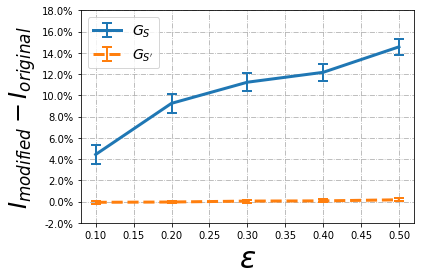

In [9]:
plot(graph_type='Email', graph_weight='unweighted', \
         GAMMA=0.24, TAU=0.06)

### The experimental results for the Airport network are replicated as follows:

1. `run main.py --graph_type=Airport --mode=equalAlpha --numExp=1 --weighted=1 --save_result=1`;
2. `run sis_simulations.py --graph_type=Email --numExp=1 --gamma=0.24 --tau=0.2 --weighted=weighted --numSim=2000`;
3. run the following code to generate the plot:

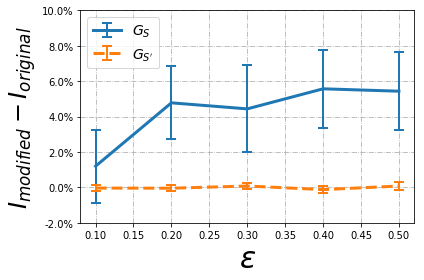

In [7]:
plot(graph_type='Airport', graph_weight='weighted', \
         GAMMA=0.24, TAU=0.2)

### The experimental results for the Brain network are replicated as follows:

1. `run main.py --graph_type=Brain --mode=equalAlpha --numExp=1 --weighted=1 --save_result=1`;
2. `run sis_simulations.py --graph_type=Email --numExp=1 --gamma=0.24 --tau=0.2 --weighted=weighted --numSim=2000`;
3. run the following code to generate the plot:

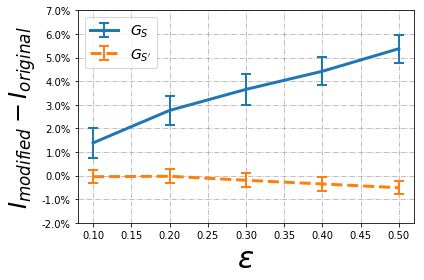

In [8]:
plot(graph_type='Brain', graph_weight='weighted', \
         GAMMA=0.24, TAU=0.2)

### We use a sub-network from the [Amazon](https://snap.stanford.edu/data/com-Amazon.html) co-purchasing network as an example to show how to run POTION on other networks;
1. A sub-network with $475$ nodes is extracted from the Amazon co-purchasing network; the sub-network is saved to `amazon_subgraph.edgelist` in edgelist format;
2. The node with highest degree and its neighbors are selected as the targeted subgraph, which is saved into `targeted_set.txt`;
3. Modify the `gen_graph` function to read the sub-network like [this](https://github.com/marsplus/POTION/blob/9e7ac6f7e4608637b22647d60c3ad27ad7e7bbc1/src/utils.py#L141-L142);
4. Modify the `select_target_subgraph` function to read node ID of the targeted sub-network like [this](https://github.com/marsplus/POTION/blob/9e7ac6f7e4608637b22647d60c3ad27ad7e7bbc1/src/utils.py#L98-L100);
5. Finally, run POTION on the sub-network. Notice that the Amazon co-purchasing as well as the extracted sub-network are unweighted.
```
run main.py --graph_type=Amazon --mode=equalAlpha --numExp=1 --weighted=0 --save_result=1
```